# Lab 1: Local feature detection
This is a notebook, which could help you with testing second lab assignment.
It contains utility functions for visualization, some test input for the functions you needs to implement,
and the output of the reference solution for the same test input.

template functions for the assignment contain a short description of what the function is supposed to do,
and produce an incorrect output, which is nevertheless in proper format: type and shape.

You are not allowed to use kornia or opencv or any other library functions, which are specifically designed
to perform the operations requested in assignment

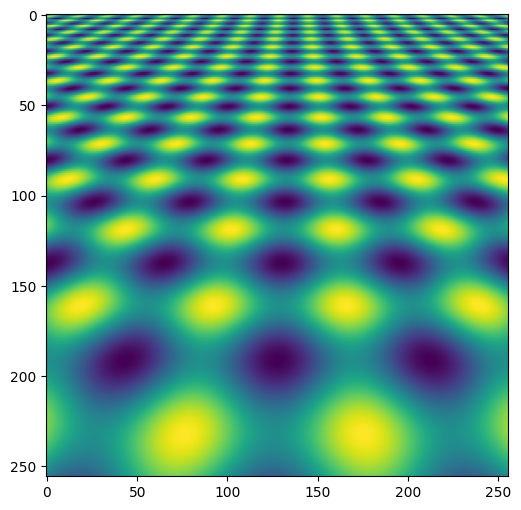

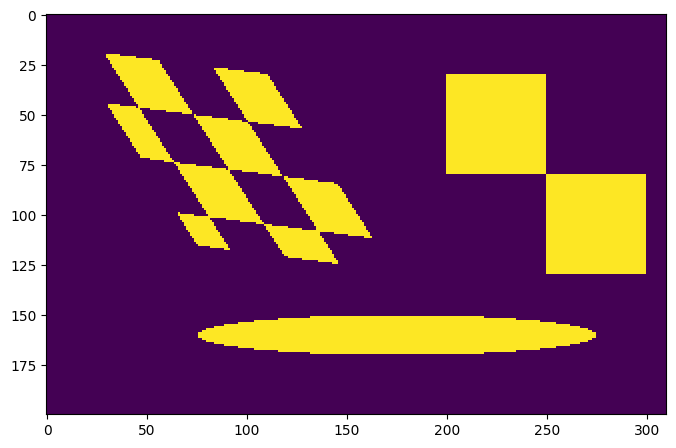

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import torch
import kornia
import cv2


# Visualization functions
def plot_torch(x, y, *kwargs):
    plt.plot(x.detach().cpu().numpy(), y.detach().cpu().numpy(), *kwargs)
    return

def imshow_torch(tensor,figsize=(8,6), *kwargs):
    plt.figure(figsize=figsize)
    plt.imshow(kornia.tensor_to_image(tensor), *kwargs)
    return

def imshow_torch_channels(tensor, dim = 1, *kwargs):
    num_ch = tensor.size(dim)
    fig=plt.figure(figsize=(num_ch*5,5))
    tensor_splitted = torch.split(tensor, 1, dim=dim)
    for i in range(num_ch):
        fig.add_subplot(1, num_ch, i+1)
        plt.imshow(kornia.tensor_to_image(tensor_splitted[i].squeeze(dim)), *kwargs)
    return

def timg_load(fname, to_gray = True):
    img = cv2.imread(fname)
    with torch.no_grad():
        timg = kornia.image_to_tensor(img, False).float()
        if to_gray:
            timg = kornia.color.bgr_to_grayscale(timg)
        else:
            timg = kornia.color.bgr_to_rgb(timg)
    return timg

img_blobs = timg_load('sin.png')

# Source https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_corner.html
img_corners = timg_load('corners.png')

imshow_torch(img_blobs)
imshow_torch(img_corners)

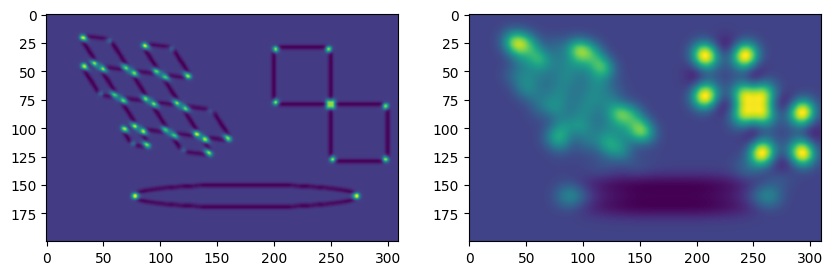

In [2]:
from local_detector import harris_response

resp_small = harris_response(img_corners, 1.6, 2.0, 0.04)
resp_big = harris_response(img_corners, 7., 9., 0.04)

imshow_torch_channels(torch.cat([resp_small, 
                                 resp_big], dim=0), 0)

## Reference example

```python
from local_detector import harris_response

resp_small = harris_response(img_corners, 1.6, 2.0, 0.04)
resp_big = harris_response(img_corners, 7., 9., 0.04)

imshow_torch_channels(torch.cat([resp_small, 
                                 resp_big], dim=0), 0)
```
![image.png](local_detector_files/att_00001.png)
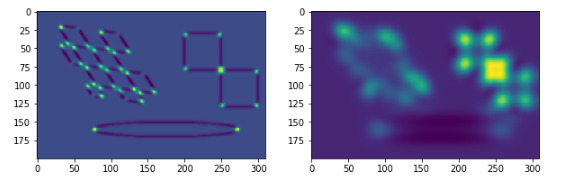

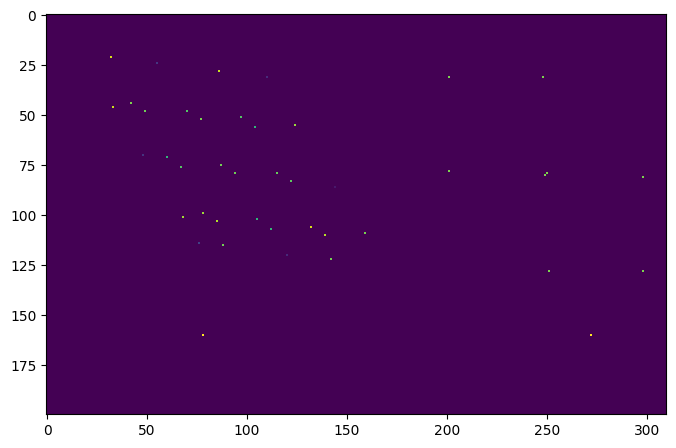

In [3]:
from local_detector import nms2d

nmsed_harris = nms2d(resp_small, 1e-6)

imshow_torch(nmsed_harris)


## Reference example

```python
from local_detector import nms2d

nmsed_harris = nms2d(resp_small, 1e-6)

imshow_torch(nmsed_harris)
```
![local_detector_files/att_00002.png](local_detector_files/att_00002.png)
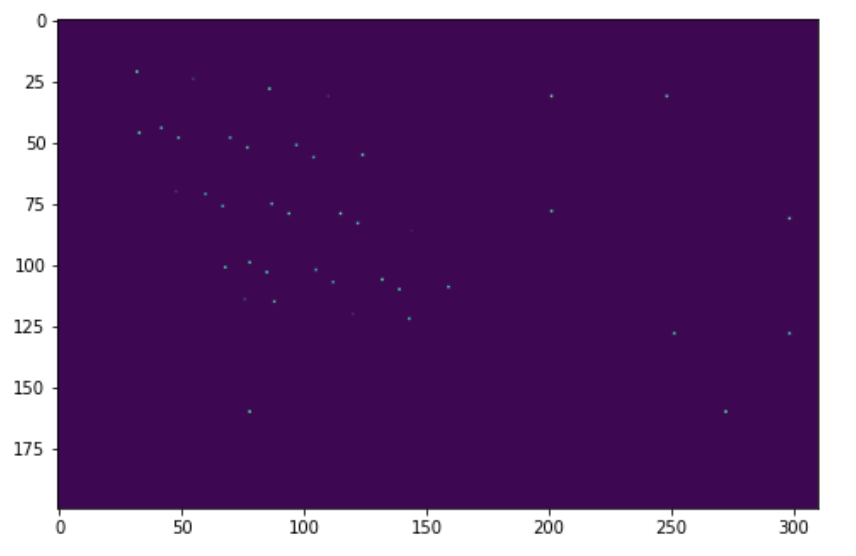

In [4]:
from local_detector import harris
# import cv2 as cv
# gray = cv.cvtColor(img_corners.cpu().detach().numpy().squeeze(),cv.COLOR_GRAY2RGB)
# gray = cv.cvtColor(gray, cv.COLOR_RGB2GRAY)
# dst = cv.cornerHarris(gray,9,9,0.04)
# threshold = 0.00001
# print(np.nonzero(dst > threshold))
keypoint_locations = harris(img_corners, 1.6, 2.0, 0.00001)
print (keypoint_locations)


tensor([[  0,   0,  16,  29],
        [  0,   0,  16,  30],
        [  0,   0,  16,  31],
        ...,
        [  0,   0, 165, 273],
        [  0,   0, 165, 274],
        [  0,   0, 165, 275]])


## Reference example

```python
from local_detector import harris

keypoint_locations = harris(img_corners, 1.6, 2.0, 0.00001)
print (keypoint_locations)
```

    tensor([[  0,   0,  21,  32],
            [  0,   0,  28,  86],
            [  0,   0,  31, 201],
            [  0,   0,  31, 248],
            [  0,   0,  44,  42],
            [  0,   0,  46,  33],
            [  0,   0,  48,  49],
            [  0,   0,  48,  70],
            [  0,   0,  51,  97],
            [  0,   0,  52,  77],
            [  0,   0,  55, 124],
            [  0,   0,  56, 104],
            [  0,   0,  71,  60],
            [  0,   0,  75,  87],
            [  0,   0,  76,  67],
            [  0,   0,  78, 201],
            [  0,   0,  79,  94],
            [  0,   0,  79, 115],
            [  0,   0,  81, 298],
            [  0,   0,  83, 122],
            [  0,   0,  99,  78],
            [  0,   0, 101,  68],
            [  0,   0, 102, 105],
            [  0,   0, 103,  85],
            [  0,   0, 106, 132],
            [  0,   0, 107, 112],
            [  0,   0, 109, 159],
            [  0,   0, 110, 139],
            [  0,   0, 115,  88],
            [  0,   0, 122, 143],
            [  0,   0, 128, 251],
            [  0,   0, 128, 298],
            [  0,   0, 160,  78],
            [  0,   0, 160, 272]])

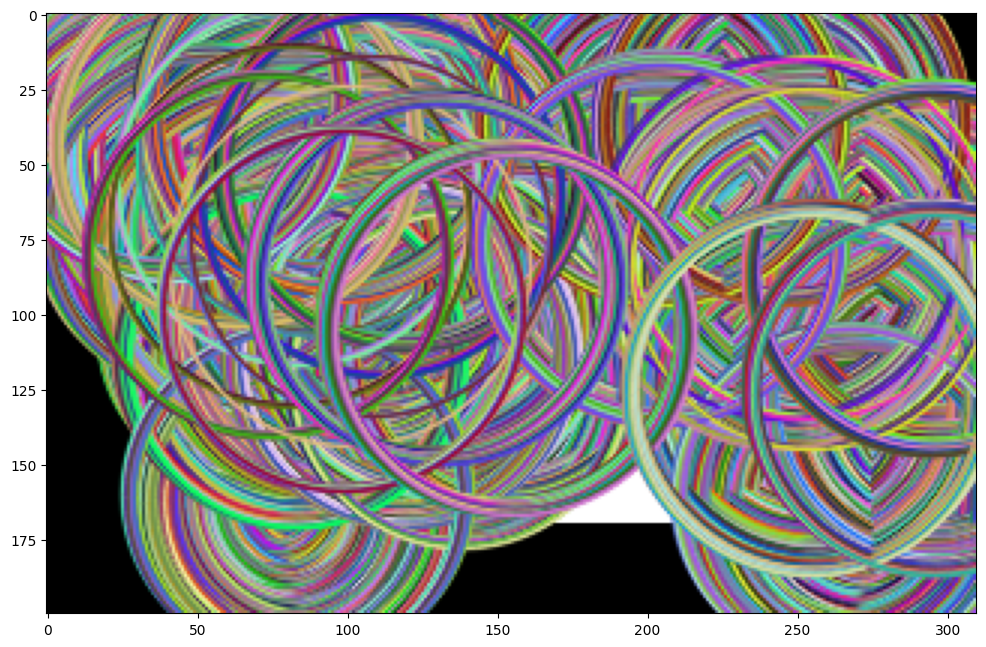

In [11]:
from local_detector import scalespace_harris
from imagefiltering import gaussian_filter2d

def visualize_detections(img, keypoint_locations, img_idx = 0, increase_scale = 1.):
    # Select keypoints relevant to image   
    kpts = [cv2.KeyPoint(b_ch_sc_y_x[4].item(),
                         b_ch_sc_y_x[3].item(),
                         increase_scale * b_ch_sc_y_x[2].item())
            for b_ch_sc_y_x in keypoint_locations if b_ch_sc_y_x[0].item() == img_idx]
    vis_img = None
    vis_img = cv2.drawKeypoints(kornia.tensor_to_image(img).astype(np.uint8),
                                kpts,
                                vis_img, 
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(12,10))
    plt.imshow(vis_img)
    return


with torch.no_grad():
    keypoint_locations = scalespace_harris(img_corners, 0.00001)

visualize_detections(img_corners*255., keypoint_locations, increase_scale=8.0)

In [12]:
keypoint_locations.shape

torch.Size([40429, 5])

## Reference example

```python
from local_detector import scalespace_harris
from imagefiltering import gaussian_filter2d

with torch.no_grad():
    keypoint_locations = scalespace_harris(img_corners, 0.00001)

visualize_detections(img_corners*255., keypoint_locations, increase_scale=8.0)
```
![image-2.png](local_detector_files/att_00007.png)
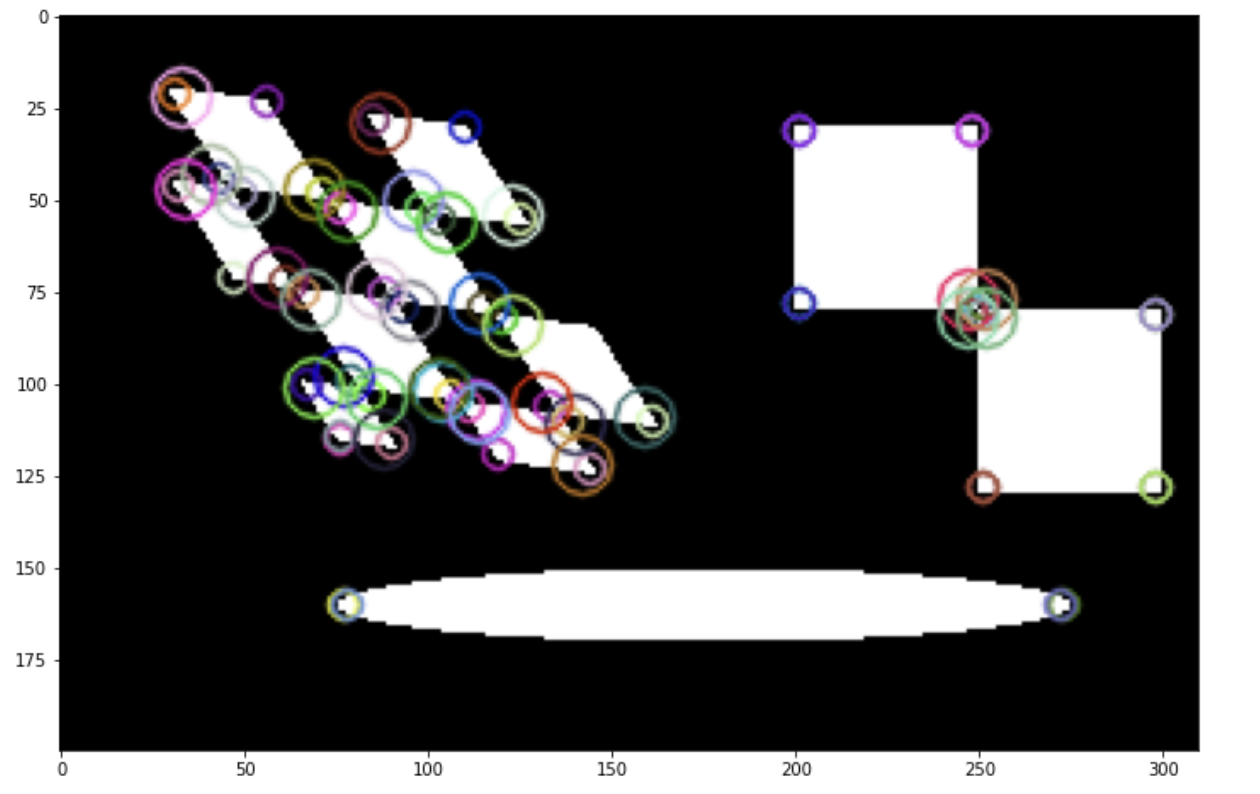